In [1]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import numpy as np
from matplotlib import pyplot as plt
import time
from tqdm.notebook import trange, tqdm
import pandas as pd

# Pour torch si vous avez un GPU
# device = "cpu" if not torch.cuda.is_available() else "cuda"
device = "cpu" # Pour forcer l'utilisation du CPU

# Agent qui utilise les LSTM et de l'exploration

In [2]:
from environnement.environnement import Environnement as env # mother class
from environnement.small_loop import small_loop

# model machine learning
from model.Tokenizer import *
from model.RNN import *
from model.CustomDataSet import CustomDataSet, CustomDataSetRNN
from outil import *
from inter.simpleInteraction import simpleInteraction as inter

# L'agent :
Nous reprennons l'agent de agentRNNv2.ipynb, nous lui ajoutons seulement un booléen qui permet de savoir si il faut faire une action aléatoire ou pas.

In [3]:
class AgentLSTM:
    def __init__(self, valence:dict[inter, float], model:nn.Module, max_depth:int, seuil:float,
                optimizer, loss_fn, gap_train:int=11, gap_predi:int=11, nb_epoch:int=100, data_validate=None):
        self.model = model
        self.valence = valence
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.gap_train = gap_train
        self.gap_predi = gap_predi
        self.nb_epoch = nb_epoch
        self.seq_to_exe = [] # Séquence d'actions et d'outcome choisit par la décision
        self.history_act = [] # Historique des actions
        self.history_fb = [] # Historique des feedbacks
        self.data_validate = data_validate
        self.max_depth:int = max_depth
        self.seuil:float = seuil
        
        self.all_outcomes = set()
        self.all_act = set()
        key:inter = None
        for key in valence.keys():
            self.all_outcomes.add(key.getOutcome())
            self.all_act.add(key.getAction())
        self.all_outcomes = list(self.all_outcomes)
        self.all_act = list(self.all_act)
        
        self.action_choice = self.all_act[0] # De base nous choisissons la première action
        self.history_act.append(self.action_choice)
        self.outcome_prediction = None # De base le modèl ne prédi rien
        
        # number_patern = np.sum([(len(self.all_act) * len(self.all_outcomes)) **i for i in range(1, self.max_depth + 1)])
        number_patern = 20000
        self.prealloc_df = pd.DataFrame(np.empty((number_patern, 4)), columns=["proposition", "valence", "action", "probability"])
        # self.prealloc_df = self.prealloc_df.astype({"proposition": "U20", "valence": float, "action": int, "probability": float})
        self.current_index = 0
        
        # Nous avons besoin d'un tokenizer pour transformer les actions et outcomes en entiers
        # Pour des questions de simplicité, nous voulons que les outcomes soient passé en premier
        self.tokenizer = SimpleTokenizerV1(
            vocab={key: i for i, key in enumerate(self.all_outcomes + self.all_act)})
        
        # Variable moniteur
        self.loss_train = [] # Contient toutes les listes des pertes d'entrainement
        self.loss_val = [] # Contient toutes les listes des pertes de validation
        self.acc_train = []
        self.acc_val = []
        
    def fit(self):
        """
        Fonction de l'agent pour entrainer le modèle
        """        
        dataset = CustomDataSetRNN(actions=self.history_act, outcomes=self.history_fb, 
                                 context_lenght=self.gap_train, dim_out=len(self.all_outcomes),
                                 tokenizer=self.tokenizer)
        
        data_loader = DataLoader(dataset, batch_size=16, shuffle=True)
        
        if self.data_validate is not None:
            dataset_test = CustomDataSetRNN(actions=self.data_validate[0], outcomes=self.data_validate[1], 
                                 context_lenght=self.gap_train, dim_out=len(self.all_outcomes),
                                 tokenizer=self.tokenizer)
            data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
            loss_test = []
        
        for _ in range(self.nb_epoch):
            self.model.train()
            steps = 0
            train_acc = 0
            training_loss = []
            for tmp, (x,t) in enumerate(data_loader):
                bs = t.shape[0]
                x = x.to(device)
                t = t.to(device)
                h = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=device)
                cell = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=device)

                pred, h, cell = self.model(x, h, cell)

                loss = self.loss_fn(pred[:, -1, :], t)
                training_loss.append(loss.item())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                
                
                train_acc += sum((pred[:, -1, :].argmax(1) == t).cpu().numpy())
                steps += bs
                
            self.acc_train.append(train_acc / steps)
            
            if self.data_validate is not None:
                self.model.eval()
                steps = 0
                test_acc = 0
                loss_test = []
                
                for text, label in data_loader_test:
                    text = text.to(device)
                    label = label.to(device)
                    bs = label.shape[0]

                    # Initialize hidden and memory states
                    hidden = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=device)
                    memory = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=device)
                    
                    # Forward pass through the model
                    pred, hidden, memory = self.model(text, hidden, memory)

                    # Calculate the loss
                    loss = self.loss_fn(pred[:, -1, :], label)
                    loss_test.append(loss.item())

                    # Calculate test accuracy
                    test_acc +=  sum((pred[:, -1, :].argmax(1) == label).cpu().numpy())
                    steps += bs
                    
                loss_test.append(loss_test)
                self.acc_val.append(test_acc / steps)
                
            self.loss_train.append(training_loss)
                
    def predict(self, action):
        """
        Fonction de l'agent pour prédire l'outcome en fonction de l'action \
        utilise l'historique des actions et outcomes comme contexte

        Args:
            action : L'action dont on prédit l'outcome 

        Raises:
            Exception: Si l'historique des actions et outcomes est insuffisant

        Returns:
            out : L'outcome prédit
        """        
        # Nous devons recupérer les gap dernières actions/outcomes
        x = []
        for i in range(-(self.gap_predi - 1) // 2, 0, 1):
            x.append(self.history_act[i])
            x.append(self.history_fb[i])
        x.append(action)
        seq_to_pred = self.tokenizer.encode(x)
        # On simule un batch de taille 1
        seq_to_pred = torch.tensor([seq_to_pred], device=device)
        h = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)
        cell = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)
        probs, _, _ = self.model(seq_to_pred, h, cell)
        
        pred_feedback = torch.argmax(probs[:, -1, :]).item()
        pred_feedback = self.tokenizer.decode(pred_feedback)
        
        return pred_feedback
    
    def recursif_expective_valance(self, context:list, max_depth:int, seuil:float=0.2, proba:float = 1, seq_predi:list = [], valence_precedente:float = 0):
        """
        Create the list of proposed sequences
        """
        max_depth -= 1
        self.model.eval()
        
        # print('debug recu val :')
        # print("probabilite", proba)
        # print("context", context)
        # print("max_depth", max_depth)
        # print("seuil", seuil)
        # print("seq_predi", seq_predi)
        
        # Compute the expected valence of each action
        for act in self.all_act:
            new_seq = seq_predi + [act]
            seq_to_predict = context + [self.tokenizer.encode(act)]
            seq_to_predict = torch.tensor([seq_to_predict], dtype=torch.int).to(device)

            hidden = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)
            memory = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)

            x, _, _ = self.model(seq_to_predict, hidden, memory)
            x = x[0, -1, :]

            # Transforme x into list proba
            probs = torch.nn.functional.softmax(x, dim=0).tolist()
            
            # for each outcome, record the expected valence
            for i, out in enumerate(self.all_outcomes):
                tmp_new_seq = new_seq + [out]
                tmp_proba = probs[i] * proba
                # If the probability is above a threshold
                if tmp_proba > seuil:
                    # Record the proposed sequence with its expected valence
                    expected_valence = float(np.round(self.valence[inter(act, out)] * tmp_proba, decimals=4)) + valence_precedente
                    self.prealloc_df.iloc[self.current_index] = [str(tmp_new_seq), expected_valence, tmp_new_seq[0], tmp_proba]
                    self.current_index += 1
                    # If the max_depth is not reached 
                    if max_depth > 0: 
                        # Recursively look for longer sequences
                        new_context = context + self.tokenizer.encode([act, out])
                        self.recursif_expective_valance(context=new_context[2:], max_depth=max_depth, seuil=seuil, 
                            proba=tmp_proba, seq_predi=tmp_new_seq.copy(), valence_precedente=expected_valence)
    
    def expective_valance(self, verbose:bool=False):
        """
        Permet de calculer l'expective valance d'une séquence d'interaction

        Args:
            max_depth (int): _description_
            seuil (float, optional): _description_. Defaults to 0.2.
            verbose (bool, optional): _description_. Defaults to False.
        """
        
        x = []
        for i in range(-(self.gap_predi - 1) // 2, 0, 1):
            x.append(self.history_act[i])
            x.append(self.history_fb[i])
        seq_to_pred = self.tokenizer.encode(x)
        self.prealloc_df[:] = np.nan
        self.prealloc_df["valence"] = -np.inf
        self.current_index = 0
        return self.recursif_expective_valance(context=seq_to_pred,
                                            max_depth=self.max_depth,
                                            proba=1, seq_predi=[],
                                            seuil=self.seuil)
    def decide(self):
        if self.seq_to_exe and len(self.seq_to_exe) > 1:
            out = self.seq_to_exe.pop(0)
            if out == self.history_fb[-1]:
                act = self.seq_to_exe.pop(0)
                return act
            else:
                self.seq_to_exe = []
        self.seq_to_exe = []        
        
        self.expective_valance()
        self.seq_to_exe = self.prealloc_df.sort_values(by="valence", ascending=False).iloc[0].proposition
        self.seq_to_exe = eval(self.seq_to_exe)
        print("after compute ...")
        print(self.seq_to_exe)
        act = self.seq_to_exe.pop(0)
        return act
        
    def action(self, real_outcome, verbose=False, explore:bool=False):
        """
        La fonction action permet à l'agent de choisir une action en fonction de l'outcome réel.
        Cette fonction entraine le modèle a prévoir les outcomes futurs en fonction des actions passées.

        Args:
            real_outcome : L'outcome réel suite à l'action de l'agent
            verbose : Affiche les informations sur l'entrainement ou non
        """
        # La première étape est de sauvegarder l'outcome réel
        self.history_fb.append(real_outcome)
        good_pred:bool = self.outcome_prediction == real_outcome
        if verbose :
            print(f"\033[0;31m Action: {self.action_choice} \033[0m, Prediction: {self.outcome_prediction}, Outcome: {real_outcome}, \033[0;31m Satisfaction: {good_pred} \033[0m")
        
        # Ensuite nous regardons si nous devons entrainer le modèle
        # not(explore) and 
        if not(explore):
            if not(good_pred) and len(self.history_fb) + len(self.history_fb) > self.gap_train:
                self.fit()
            elif len(self.history_fb) + len(self.history_fb) > self.gap_train:
                for _ in range(self.nb_epoch):
                    self.acc_train.append(self.acc_train[-1])
                    self.acc_val.append(self.acc_val[-1])

        # Nous devons maintenant choisir une action
        if explore:
            self.action_choice = np.random.choice(self.all_act)
        else:
            if len(self.history_fb) + len(self.history_fb) > self.gap_predi:
                self.action_choice = self.decide()
                self.outcome_prediction = self.predict(self.action_choice)
            else:
                self.action_choice = np.random.choice(self.all_act)
        # self.action_choice = np.random.choice(self.all_act)
        self.history_act.append(self.action_choice)
        
        return self.action_choice, self.outcome_prediction
        
        
              

# Rappel
Pour donner un bon comportement a notre robot nous allons essayer avec cette valence :
- forward, empty : 1
- forward, wall : -30  `Nous voulons que le robot évite les murs`
- turn_left, empty : -7
- turn_left, wall : -7 `Cas impossible, mais nous devons le noter`
- turn_right, empty : -7
- turn_right, wall : -7 `Cas impossible, mais nous devons le noter`
- feel_front, wall : -5
- feel_front, empty : -5

In [ ]:
environenment = small_loop(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1],
                [1, 0, 1, 0, 1],
                [1, 0, 0, 0, 1],
                [1, 1, 1, 1, 1],
            ]))


valence = {
    inter('forward', 'empty') : 1,
    inter('forward', 'wall') : -30,
    inter('turn_left', 'empty') : -7,
    inter('turn_left', 'wall') : -7,
    inter('turn_right', 'empty') : -7,
    inter('turn_right', 'wall') : -7,
    inter('feel_front', 'wall') : -7,
    inter('feel_front', 'empty') : -7,
}

In [5]:
# torch.manual_seed(0)
# np.random.seed(0)
hidden_size = 16
num_layers = 1
len_vocab = len(environenment.get_outcomes() + environenment.get_actions())

# Create the LSTM classifier model
lstm_classifier = LSTM(num_emb=len_vocab, output_size=2, 
                       num_layers=num_layers, hidden_size=hidden_size, dropout=0.2).to(device)

optimizer = torch.optim.Adam(lstm_classifier.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(create_dico_numerate_word(environenment.get_outcomes() + environenment.get_actions()))

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [ ]:
# Pour évaluler la performance du modèle
act_val, fb_val = [], []
    action = np.random.choice(environenment.get_actions())
    outcome = environenment.outcome(action)
    act_val.append(action)
    fb_val.append(outcome)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
agent = AgentLSTM(valence=valence, model=lstm_classifier, optimizer=optimizer, loss_fn=loss_func,
    gap_predi=11, gap_train=11, max_depth=4, seuil=0.5, nb_epoch=50,
    data_validate=(act_val, fb_val))
outcome = environenment.outcome(agent.action_choice)

In [8]:
history_good = []
history_good_inter = []
history_bad_inter = []
hisrory_val = []
pourcent_by_10  = []
by_10_good_inter  = []
by_10_bad_inter  = []
mean_val = []

In [9]:
# Exploration de l'agent :

for i in tqdm(range(1000)):
    action, predi = agent.action(outcome, explore=True)
    outcome = environenment.outcome(action)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
# torch.manual_seed(0)
# np.random.seed(0)

for i in tqdm(range(100)):
    action, predi = agent.action(outcome, verbose=True)
    df = agent.prealloc_df
    outcome = environenment.outcome(action)
    history_good.append(outcome == predi)
    history_good_inter.append((action == 'forward' and outcome == 'empty'))
    history_bad_inter.append((action == 'forward' and outcome == 'wall'))
    hisrory_val.append(valence[inter(action, outcome)])
    
    pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
    by_10_good_inter.append(sum(history_good_inter[-10:]) if len(history_good_inter) >= 10 else 0)
    by_10_bad_inter.append(sum(history_bad_inter[-10:]) if len(history_bad_inter) >= 10 else 0)
    mean_val.append(np.mean(hisrory_val[-10:]) if len(hisrory_val) >= 10 else 0)
    
    environenment.save_world()

  0%|          | 0/100 [00:00<?, ?it/s]

 Action: turn_left , Prediction: None, Outcome: empty,  Satisfaction: False 


/tmp/ipykernel_7642/3421355164.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['turn_right', 'empty']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.prealloc_df.iloc[self.current_index] = [str(tmp_new_seq), expected_valence, tmp_new_seq[0], tmp_proba]
/tmp/ipykernel_7642/3421355164.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'turn_right' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.prealloc_df.iloc[self.current_index] = [str(tmp_new_seq), expected_valence, tmp_new_seq[0], tmp_proba]


after compute ...
['turn_right', 'empty', 'turn_right', 'empty', 'forward', 'empty', 'forward', 'empty']
 Action: turn_right , Prediction: empty, Outcome: empty,  Satisfaction: True 
 Action: turn_right , Prediction: empty, Outcome: empty,  Satisfaction: True 
 Action: forward , Prediction: empty, Outcome: wall,  Satisfaction: False 
after compute ...
['turn_right', 'empty', 'turn_right', 'empty', 'forward', 'empty', 'forward', 'empty']
 Action: turn_right , Prediction: empty, Outcome: empty,  Satisfaction: True 
 Action: turn_right , Prediction: empty, Outcome: empty,  Satisfaction: True 
 Action: forward , Prediction: empty, Outcome: empty,  Satisfaction: True 
 Action: forward , Prediction: empty, Outcome: empty,  Satisfaction: True 
after compute ...
['turn_right', 'empty', 'forward', 'empty', 'forward', 'empty']
 Action: turn_right , Prediction: empty, Outcome: empty,  Satisfaction: True 
 Action: forward , Prediction: empty, Outcome: wall,  Satisfaction: False 
after compute ...


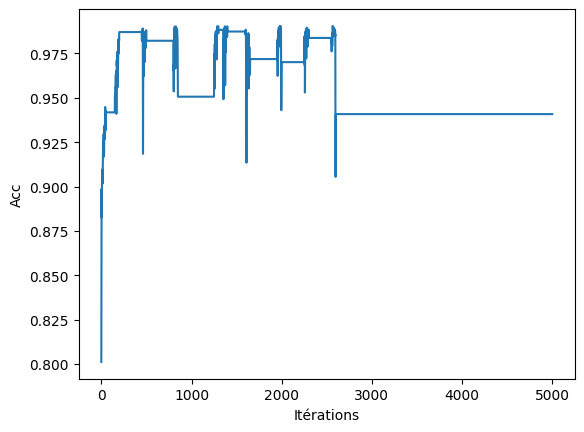

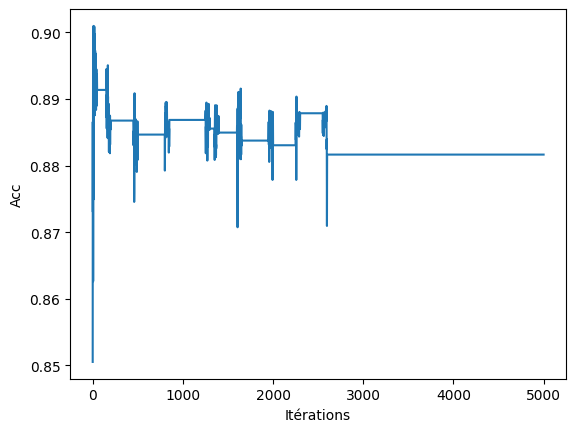

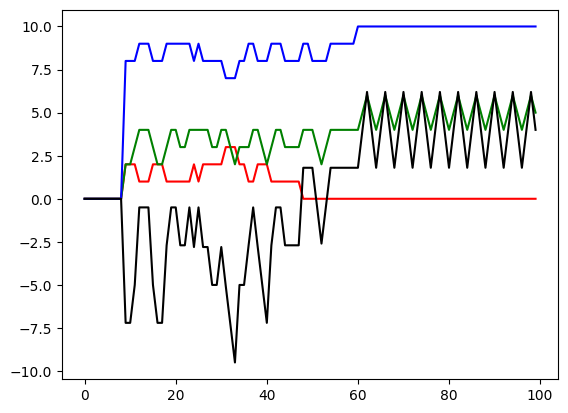

In [11]:
# see_evolued_loss(agent.loss_train)
# see_evolued_loss(agent.loss_val)
see_evolued_acc(agent.acc_train)
see_evolued_acc(agent.acc_val)

pourcent_by_10 = [i / 10 for i in pourcent_by_10]
plt.plot(by_10_bad_inter, label=f'bad inter', color='red')
plt.plot(by_10_good_inter, label=f'good inter', color='green')
plt.plot(pourcent_by_10, label=f'global', color='blue')
plt.plot(mean_val, label=f'mean valence', color='black')
plt.show()
plt.close()



# Résultat
L'aléatoire rend chaque essaie non déterministe. Mais on peut voir qu'avec suiffisament d'exploration, on trouve de bon comportement. A noter que l'accuracie du train monte facilement a 100% mais pas celui de la validation, ce qui n'empeche pas le robot d'avoir un bon comportement. En effet ne pas savoir se qu'il se passe dans de mauvais cas n'influance pas le robot.


In [12]:
# from sklearn.manifold import TSNE
# import plotly.graph_objs as go
# import plotly.offline as py

# # Get weights
# embds = agent.model.embedding.weight.detach().cpu().numpy()

# # Plotting function
# def plot_words(data, start, stop, step):
#     trace = go.Scatter(
#         x = data[start:stop:step, 0], 
#         y = data[start:stop:step, 1],
#         mode = 'markers',
#         text = [tokenizer.decode(i) for i in range(start, stop, step)]
#     )
#     layout = dict(title= 't-SNE 1 vs t-SNE 2',
#                   yaxis = dict(title='t-SNE 2'),
#                   xaxis = dict(title='t-SNE 1'),
#                   hovermode= 'closest')
#     fig = dict(data = [trace], layout= layout)
#     py.iplot(fig)

# # Visualize words in two dimensions 
# # Set perplexity to a value less than the number of samples
# perplexity_value = min(30, len(embds) - 1)  # Ensure perplexity is less than the number of samples
# conv_tsne_embds = TSNE(n_components=2, perplexity=perplexity_value).fit_transform(embds)
# plot_words(conv_tsne_embds, 0, len(embds), 1)